In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df=pd.read_excel('/content/E-com_Data.xlsx')

In [6]:
df.head()

,CustomerID,Item Code,InvoieNo,Date of purchase,Quantity,Time,price per Unit,Price,Shipping Location,Cancelled_status,Reason of return,Sold as set
0,4355.0,15734,398177,2017-10-29,6,15:36:00,321.0,1926.0,Location 1,NaN,NaN,NaN
1,4352.0,14616,394422,2017-10-05,2,14:53:00,870.0,1740.0,Location 1,NaN,NaN,NaN
2,4352.0,14614,394422,2017-10-12,2,14:53:00,933.0,1866.0,Location 1,NaN,NaN,NaN
3,4352.0,85014B,388633,2017-08-22,3,14:47:00,623.0,1869.0,Location 1,NaN,NaN,NaN
4,4352.0,15364,394422,2017-10-10,2,14:53:00,944.0,1888.0,Location 1,NaN,NaN,NaN


In [10]:
df=df.drop(['Cancelled_status','Reason of return','Sold as set'],axis=1)

In [11]:
df.isnull().sum()

CustomerID           133790
Item Code                 0
InvoieNo                  0
Date of purchase          0
Quantity                  0
Time                      0
price per Unit            0
Price                     0
Shipping Location         0
dtype: int64

In [12]:
df=df.dropna()

In [13]:
df.isnull().sum()

CustomerID           0
Item Code            0
InvoieNo             0
Date of purchase     0
Quantity             0
Time                 0
price per Unit       0
Price                0
Shipping Location    0
dtype: int64

In [14]:
df.shape

(404189, 9)

In [15]:
location_customer=df[['Shipping Location','CustomerID']].drop_duplicates()
location_customer.groupby(['Shipping Location'])['CustomerID'].aggregate('count').reset_index().sort_values('CustomerID', ascending=False)

,Shipping Location,CustomerID
15,Location 36,4347
10,Location 26,1886
3,Location 14,1712
4,Location 15,1500
0,Location 1,1032
2,Location 11,976
16,Location 37,473
9,Location 25,368
6,Location 21,341
5,Location 20,252


In [16]:
df = df[(df['Quantity']>0)]

In [17]:
df.Quantity.min()

1

In [19]:
df.describe()

,CustomerID,InvoieNo,Quantity,price per Unit,Price
count,396006.000000,396006.000000,396006.000000,396006.000000,396006.000000
mean,2186.435031,385683.539363,11.822546,338.625269,2554.896987
std,1252.326552,13107.531763,29.666734,424.300411,4903.384347
min,2.000000,361429.000000,1.000000,2.000000,12.000000
25%,1212.000000,374298.000000,2.000000,157.000000,598.000000
50%,2080.000000,386957.000000,6.000000,237.000000,1608.000000
75%,3294.000000,397157.000000,12.000000,403.000000,2520.000000
max,4372.000000,406651.000000,3186.000000,64973.000000,90400.000000


In [21]:
df['Date of purchase'] = pd.to_datetime(df['Date of purchase'])

In [22]:
df.dtypes

CustomerID                  float64
Item Code                    object
InvoieNo                      int64
Date of purchase     datetime64[ns]
Quantity                      int64
Time                         object
price per Unit              float64
Price                       float64
Shipping Location            object
dtype: object

In [25]:
df['Date of purchase'].max()

Timestamp('2017-12-19 00:00:00')

In [27]:
import datetime as dt

#Set Latest date 2011-12-10 as last invoice date was 2011-12-09. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2017,12,20)

#Create RFM Modelling scores for each customer
RFMScores = df.groupby('CustomerID').agg({'Date of purchase': lambda x: (Latest_Date - x.max()).days, 'InvoieNo': lambda x: len(x), 'Price': lambda x: x.sum()})

#Convert Invoice Date into type int
RFMScores['Date of purchase'] = RFMScores['Date of purchase'].astype(int)

#Rename column names to Recency, Frequency and Monetary
RFMScores.rename(columns={'Date of purchase': 'Recency', 
                         'InvoieNo': 'Frequency', 
                         'Price': 'Monetary'}, inplace=True)

RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary
0,2.0,4,182,553704.0
1,3.0,77,27,257404.0
2,4.0,19,72,176613.0
3,5.0,311,16,41976.0
4,6.0,37,77,166972.0


In [30]:
quantiles = RFMScores.quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()
quantiles

{'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 100.0},
 'Monetary': {0.25: 39288.0, 0.5: 86147.0, 0.75: 210833.75},
 'Recency': {0.25: 19.0, 0.5: 52.0, 0.75: 143.25}}

In [31]:
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [32]:
RFMScores['R'] = RFMScores['Recency'].apply(RScoring, args=('Recency',quantiles,))
RFMScores['F'] = RFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
RFMScores['M'] = RFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
2.0,4,182,553704.0,1,1,1
3.0,77,27,257404.0,3,3,1
4.0,19,72,176613.0,1,2,2
5.0,311,16,41976.0,4,4,3
6.0,37,77,166972.0,2,2,2


In [33]:
RFMScores['RFMGroup'] = RFMScores.R.map(str) + RFMScores.F.map(str) + RFMScores.M.map(str)

#Calculate and Add RFMScore value column showing total sum of RFMGroup values
RFMScores['RFMScore'] = RFMScores[['R', 'F', 'M']].sum(axis = 1)
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore
CustomerID,,,,,,,,
2.0,4,182,553704.0,1,1,1,111,3
3.0,77,27,257404.0,3,3,1,331,7
4.0,19,72,176613.0,1,2,2,122,5
5.0,311,16,41976.0,4,4,3,443,11
6.0,37,77,166972.0,2,2,2,222,6


In [34]:
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(RFMScores.RFMScore, q = 4, labels = Loyalty_Level)
RFMScores['RFM_Loyalty_Level'] = Score_cuts.values
RFMScores.reset_index().head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level
0,2.0,4,182,553704.0,1,1,1,111,3,Platinum
1,3.0,77,27,257404.0,3,3,1,331,7,Gold
2,4.0,19,72,176613.0,1,2,2,122,5,Platinum
3,5.0,311,16,41976.0,4,4,3,443,11,Bronze
4,6.0,37,77,166972.0,2,2,2,222,6,Gold


In [36]:
##Kmeans

In [37]:
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num
#Apply handle_neg_n_zero function to Recency and Monetary columns 
RFMScores['Recency'] = [handle_neg_n_zero(x) for x in RFMScores.Recency]
RFMScores['Monetary'] = [handle_neg_n_zero(x) for x in RFMScores.Monetary]

In [38]:
Log_Tfd_Data = RFMScores[['Recency', 'Frequency', 'Monetary']].apply(np.log, axis = 1).round(3)

In [39]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = RFMScores.index, columns = Log_Tfd_Data.columns)

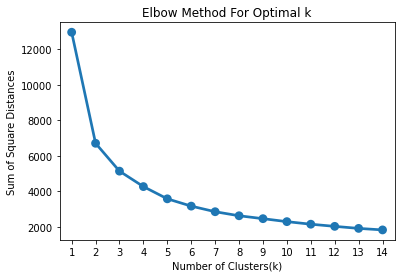

In [41]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
import seaborn as sns
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [42]:
# from elbow curve the optimal k value us 3

In [43]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 3, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
RFMScores['Cluster'] = KMean_clust.labels_
RFMScores.head()

,Recency,Frequency,Monetary,R,F,M,RFMGroup,RFMScore,RFM_Loyalty_Level,Cluster
CustomerID,,,,,,,,,,
2.0,4,182,553704.0,1,1,1,111,3,Platinum,0
3.0,77,27,257404.0,3,3,1,331,7,Gold,2
4.0,19,72,176613.0,1,2,2,122,5,Platinum,2
5.0,311,16,41976.0,4,4,3,443,11,Bronze,1
6.0,37,77,166972.0,2,2,2,222,6,Gold,2


<Figure size 504x504 with 0 Axes>

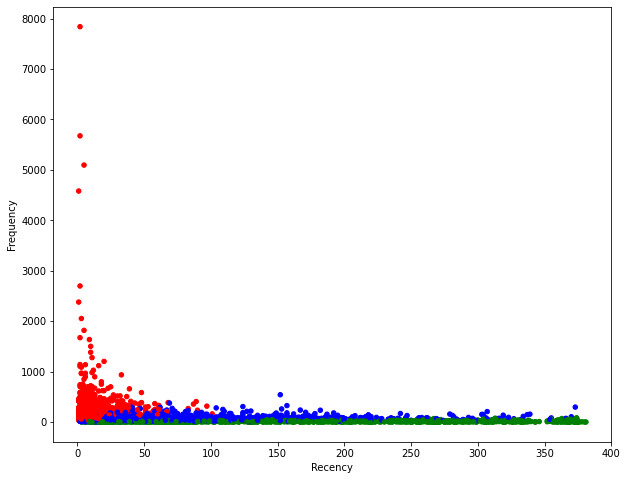

In [45]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Recency
Colors = ["red", "green", "blue"]
RFMScores['Color'] = RFMScores['Cluster'].map(lambda p: Colors[p])
ax = RFMScores.plot(    
    kind="scatter", 
    x="Recency", y="Frequency",
    figsize=(10,8),
    c = RFMScores['Color']
)